In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from tqdm import tqdm
import xarray as xr
import os, sys
import scipy
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from scipy import stats

from scipy import interpolate

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from allenAnalysis.utils import *

%matplotlib ipympl

In [2]:
from allenAnalysis.icsd import StandardCSD, DeltaiCSD, StepiCSD

In [3]:
import matplotlib

font = {'size'   : 12}

matplotlib.rc('font', **font)

In [4]:
matplotlib.rcParams['savefig.pad_inches'] = 0

In [5]:
def plotFig(ax,csd,breaks=None,absmax=None,timeLimited=False):

    if breaks is not None:
        for b in breaks:
            ax.plot([0,3000],[b,b],c='k')

    if absmax is None:
        absmax = np.max(np.abs(csd))/2
        plotCB = True
    else:
        plotCB = False
    
    im = ax.imshow(np.array(csd), origin='lower', vmin =-absmax,vmax=absmax, cmap='bwr_r')#, interpolation='gaussian')
    ax.axis(ax.axis('tight'))

    if plotCB:
        cb = plt.colorbar(im, ax=ax)
        cb.formatter.set_powerlimits((0,0))


    ax.set_yticklabels([])
    ax.set_xticklabels([])

    if timeLimited:
        ax.set_xlim([0,50])
    else:
        ax.set_xlim([2000,2050])

In [6]:
allCorrelations_Low = []

allCorrelations_High = []

diam = 200E-6 * pq.m                              # [m]
sigma = 0.376 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
sigma_top = 0.376 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]

for i in range(10):

    lowRes = np.load('5c60add3-8d47-411c-9659-1dcfcaf28aa4/'+str(i)+'/total.npy')
    lfpIdx = np.arange(51)
    disk_fullDensity_idx = np.arange(102,153)
    totalLFPLowRes = lowRes[:,lfpIdx]
    objective_disk_full_lowRes = lowRes[:,disk_fullDensity_idx]

    highRes = np.load('highRes/9a3f5460-b368-45e8-8622-babead7e4fc1/'+str(i)+'/total.npy')
    lfpIdx = np.arange(101)
    totalLFPHighRes = highRes[:,lfpIdx]
    disk_fullDensity_idx = np.arange(202,303)
    objective_disk_full_highRes = highRes[:,disk_fullDensity_idx]

    # Input dictionaries for each method
    
    step_input_high = {
        'lfp' : totalLFPHighRes.T * 1E-3 * pq.V,   # [mV] -> [V],
        'coord_electrode' : 20 * np.arange(0,101) * 1e-6 * pq.m,
        'sigma' : sigma,
        'h':20E-6 * pq.m ,
        'f_type' : 'gaussian',
        'f_order' : (3, 1),
    }
    
    step_input_low = {
        'lfp' : totalLFPLowRes.T * 1E-3 * pq.V,      # [mV] -> [V],
        'coord_electrode' : 40 * np.arange(0,51) * 1e-6 * pq.m,
        'sigma' : sigma,
        'h':40E-6 * pq.m ,
        'f_type' : 'gaussian',
        'f_order' : (3, 1),
    }
    
    icsd_high = StepiCSD(**step_input_high)
    icsd_low = StepiCSD(**step_input_low)


    correlations_high = []
    correlations_low = []
    for i in range(3000):
        correlations_high.append(np.corrcoef(icsd_high.get_csd()[:,i],objective_disk_full_highRes.T[:,i])[0,1])
        correlations_low.append(np.corrcoef(icsd_low.get_csd()[:,i],objective_disk_full_lowRes.T[:,i])[0,1])

    allCorrelations_Low.append(correlations_low)
    allCorrelations_High.append(correlations_high)
                

KeyboardInterrupt: 

In [ ]:
allCorrelations_Low = np.array(allCorrelations_Low)
allCorrelations_High = np.array(allCorrelations_High)

In [28]:
LowRes_low, LowRes_high = stats.norm.interval(0.95, loc = np.mean(allCorrelations_Low,axis=0), scale = np.std(allCorrelations_Low,axis=0))
HighRes_low, HighRes_high = stats.norm.interval(0.95, loc = np.mean(allCorrelations_High,axis=0), scale = np.std(allCorrelations_High,axis=0))

In [40]:
tscores = stats.ttest_ind(allCorrelations_Low, allCorrelations_High,alternative='greater').pvalue/len(allCorrelations_Low)

In [41]:
significantIdx = np.where(tscores<0.05)

In [32]:
time = np.arange(0,3000,1)

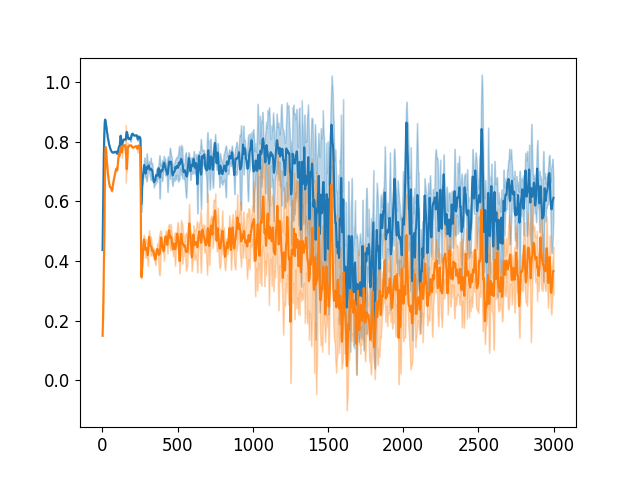

In [34]:
plt.figure()
plt.plot(np.mean(allCorrelations_Low,axis=0))
plt.fill_between(time, LowRes_low, LowRes_high, color='C0',alpha=0.3)
plt.plot(np.mean(allCorrelations_High,axis=0))
plt.fill_between(time, HighRes_low, HighRes_high, color='C1',alpha=0.3)


In [6]:
lowRes = np.load('5c60add3-8d47-411c-9659-1dcfcaf28aa4/total.npy')

lfpIdx = np.arange(51)
disk_fullDensity_idx = np.arange(102,153)
disk_halfDensity_idx = np.arange(179,205)
disk_quarterDensity_idx = np.arange(218,231)

totalLFPLowRes = lowRes[:,lfpIdx]
totalLFPLowResHalf = totalLFPLowRes[:,0:totalLFPLowRes.shape[1]:2]
totalLFPLowResQuarter = totalLFPLowRes[:,0:totalLFPLowRes.shape[1]:4]

objective_disk_full_lowRes = lowRes[:,disk_fullDensity_idx]
objective_disk_half_lowRes = lowRes[:,disk_halfDensity_idx]
objective_disk_quarter_lowRes = lowRes[:,disk_quarterDensity_idx]


In [7]:
highRes = np.load('highRes/9a3f5460-b368-45e8-8622-babead7e4fc1/total.npy')
lfpIdx = np.arange(101)
totalLFPHighRes = highRes[:,lfpIdx]
disk_fullDensity_idx = np.arange(202,303)
objective_disk_full_highRes = highRes[:,disk_fullDensity_idx]


In [8]:
highResPlane = np.load('highRes_Plane/4f1c6301-6bf9-41ed-bf00-55ec21f90669/total.npy')
disk_fullDensity_idx = np.arange(101)
objective_plane = highResPlane[:,disk_fullDensity_idx]

In [9]:
moreHighRes = np.load('MoreHighRes/5a554ca1-763c-43db-99bb-fa96472dc268/total.npy')
objective_disk_full_MoreHighRes = moreHighRes

In [10]:
moreHighRes.shape

(501, 202)

In [11]:
veryHighRes = np.load('veryHighRes/a3d9ee61-8e1e-425b-bec4-93d3dd1af238/total.npy')
lfpIdx = np.arange(401)
totalLFPVeryHighRes = veryHighRes[:,lfpIdx]
disk_fullDensity_idx = np.arange(802,1203)
objective_disk_full_VeryHighRes = veryHighRes[:,disk_fullDensity_idx]

In [34]:
import h5py
f = h5py.File('../../compartment/c6374a94-59b9-468d-8958-f7c8f876e562/0/coeffs_neuropixels_VeryHighRes.h5')


In [43]:
f['S1nonbarrel_neurons']['node_ids'].attrs['date']

'2024-08-23'

In [58]:
f.close()

In [15]:
totalLFPVeryHighRes.shape

(501, 401)

In [12]:
diam = 500E-6 * pq.m                              # [m]
sigma = 0.376 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
sigma_top = 0.376 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]

# Input dictionaries for each method

step_input_veryHigh = {
    'lfp' : totalLFPVeryHighRes.T * 1E-3 * pq.V,   # [mV] -> [V],
    'coord_electrode' : 5 * np.arange(0,401) * 1e-6 * pq.m,
    'sigma' : sigma,
    'h':5E-6 * pq.m ,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}

step_input_moreHigh = {
    'lfp' : totalLFPVeryHighRes[:,0:401:2].T * 1E-3 * pq.V,   # [mV] -> [V],
    'coord_electrode' : 10 * np.arange(0,201) * 1e-6 * pq.m,
    'sigma' : sigma,
    'h':10E-6 * pq.m ,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}

step_input_high = {
    'lfp' : totalLFPHighRes.T * 1E-3 * pq.V,   # [mV] -> [V],
    'coord_electrode' : 20 * np.arange(0,101) * 1e-6 * pq.m,
    'sigma' : sigma,
    'h':20E-6 * pq.m ,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}

step_input_low = {
    'lfp' : totalLFPLowRes.T * 1E-3 * pq.V,      # [mV] -> [V],
    'coord_electrode' : 40 * np.arange(0,51) * 1e-6 * pq.m,
    'sigma' : sigma,
    'h':40E-6 * pq.m ,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}

step_input_low_half = {
    'lfp' : totalLFPLowResHalf.T * 1E-3 * pq.V,      # [mV] -> [V],
    'coord_electrode' : 80 * np.arange(0,totalLFPLowResHalf.shape[1]) * 1e-6 * pq.m,
    'sigma' : sigma,
    'h':80E-6 * pq.m ,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}

step_input_low_quarter = {
    'lfp' : totalLFPLowResQuarter.T * 1E-3 * pq.V,      # [mV] -> [V],
    'coord_electrode' : 160 * np.arange(0,totalLFPLowResQuarter.shape[1]) * 1e-6 * pq.m,
    'sigma' : sigma,
    'h':160E-6 * pq.m ,
    'f_type' : 'gaussian',
    'f_order' : (3, 1),
}

icsd_veryHigh = StepiCSD(**step_input_veryHigh)
icsd_moreHigh = StepiCSD(**step_input_moreHigh)
icsd_high = StepiCSD(**step_input_high)
icsd_low = StepiCSD(**step_input_low)
icsd_low_half = StepiCSD(**step_input_low_half)
icsd_low_quarter = StepiCSD(**step_input_low_quarter)
        

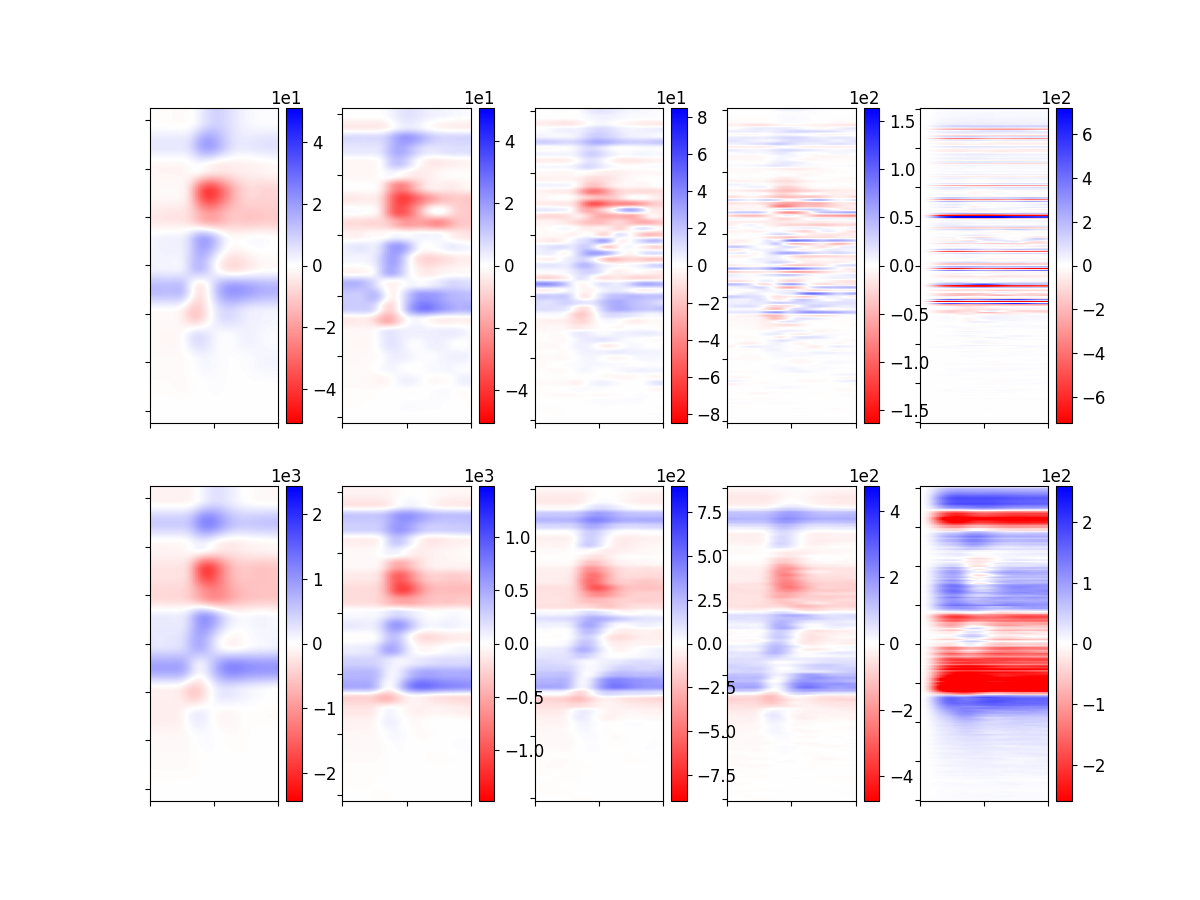

In [13]:
fig, axes = plt.subplots(2,5,figsize=(12,9))

plotFig(axes[0][0],icsd_low_quarter.get_csd())
plotFig(axes[1][0],objective_disk_quarter_lowRes.T)

plotFig(axes[0][1],icsd_low_half.get_csd())
plotFig(axes[1][1],objective_disk_half_lowRes.T)

plotFig(axes[0][2],icsd_low.get_csd())
plotFig(axes[1][2],objective_disk_full_lowRes.T)

plotFig(axes[0][3],icsd_high.get_csd())
plotFig(axes[1][3],objective_disk_full_highRes.T)

plotFig(axes[0][4],icsd_moreHigh.get_csd(),None,None,True)
plotFig(axes[1][4],objective_disk_full_MoreHighRes.T,None,None,True)

# plotFig(axes[4][0],icsd_veryHigh.get_csd(),None,None,True)
# plotFig(axes[4][1],objective_disk_full_VeryHighRes.T,None,None,True)

In [21]:
subsampled = np.zeros([objective_disk_full_VeryHighRes.shape[0],int(objective_disk_full_VeryHighRes.shape[1]/2)+1])

j = 0

for i in np.arange(0,objective_disk_full_VeryHighRes.shape[1],2):

    if i == 0:
        s = objective_disk_full_VeryHighRes[:,i]+objective_disk_full_VeryHighRes[:,i+1]/2
    elif i < objective_disk_full_VeryHighRes.shape[1]-1:
        s = objective_disk_full_VeryHighRes[:,i]+objective_disk_full_VeryHighRes[:,i+1]/2+objective_disk_full_VeryHighRes[:,i-1]/2
    else:
        s = objective_disk_full_VeryHighRes[:,i]+objective_disk_full_VeryHighRes[:,i-1]/2

    subsampled[:,j] = s

    j += 1
    

In [22]:
subsampled.shape

(501, 201)

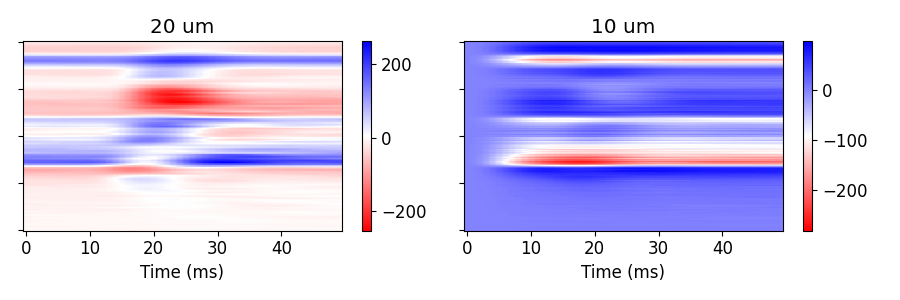

In [30]:

fig = plt.figure(figsize=(9,3))
ax = fig.add_subplot(1,2,1)

plt.title('20 um')
im = ax.imshow(objective_disk_full_highRes.T[:,2000:2050],origin='lower',cmap='bwr_r')
ax.axis(ax.axis('tight'))
plt.colorbar(im,ax=ax)
ax.set_yticklabels([])
plt.xlabel('Time (ms)')

ax = fig.add_subplot(1,2,2)

plt.title('10 um')
im = ax.imshow(objective_disk_full_VeryHighRes.T[:,:50],origin='lower',cmap='bwr_r')
ax.axis(ax.axis('tight'))
plt.colorbar(im,ax=ax)
ax.set_yticklabels([])
plt.xlabel('Time (ms)')

plt.tight_layout()

In [20]:
objective_disk_full_highRes.shape

(3000, 101)

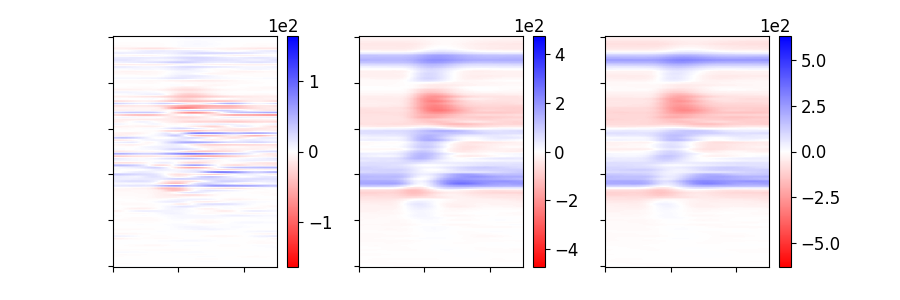

In [22]:
fig, axes = plt.subplots(1,3,figsize=(9,3))
plotFig(axes[0],icsd_high.get_csd())
plotFig(axes[1],objective_disk_full_highRes.T)
plotFig(axes[2],objective_plane.T)

In [16]:
objective_plane.shape

(3000, 101)

In [20]:
correlations_high_stim = []
correlations_low_stim = []
correlations_low_half_stim = []
correlations_low_quarter_stim = []

correlations_high_rest = []
correlations_low_rest = []
correlations_low_half_rest = []
correlations_low_quarter_rest = []

for i in np.arange(2000,2050):
    correlations_high_stim.append(np.corrcoef(icsd_high.get_csd()[:,i],objective_disk_full_highRes.T[:,i])[0,1])
    correlations_low_stim.append(np.corrcoef(icsd_low.get_csd()[:,i],objective_disk_full_lowRes.T[:,i])[0,1])
    correlations_low_half_stim.append(np.corrcoef(icsd_low_half.get_csd()[:,i],objective_disk_half_lowRes.T[:,i])[0,1])
    correlations_low_quarter_stim.append(np.corrcoef(icsd_low_quarter.get_csd()[:,i],objective_disk_quarter_lowRes.T[:,i])[0,1])

for i in np.arange(2200,2300):
    correlations_high_rest.append(np.corrcoef(icsd_high.get_csd()[:,i],objective_disk_full_highRes.T[:,i])[0,1])
    correlations_low_rest.append(np.corrcoef(icsd_low.get_csd()[:,i],objective_disk_full_lowRes.T[:,i])[0,1])
    correlations_low_half_rest.append(np.corrcoef(icsd_low_half.get_csd()[:,i],objective_disk_half_lowRes.T[:,i])[0,1])
    correlations_low_quarter_rest.append(np.corrcoef(icsd_low_quarter.get_csd()[:,i],objective_disk_quarter_lowRes.T[:,i])[0,1])

Text(0, 0.5, 'Correlation')

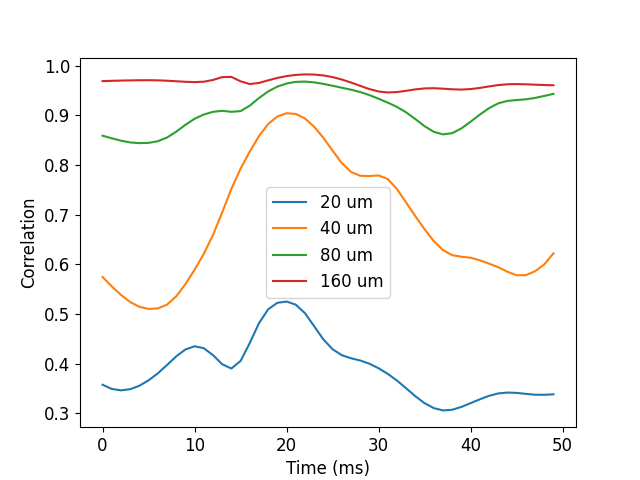

In [22]:
plt.figure()
plt.plot(correlations_high_stim,c='C0')
plt.plot(correlations_low_stim,c='C1')
plt.plot(correlations_low_half_stim,c='C2')
plt.plot(correlations_low_quarter_stim,c='C3')

# plt.plot(correlations_high_rest,'--',c='C0')
# plt.plot(correlations_low_rest,'--',c='C1')
# plt.plot(correlations_low_half_rest,'--',c='C2')
# plt.plot(correlations_low_quarter_rest,'--',c='C3')

plt.legend(['20 um', '40 um','80 um','160 um'])
plt.xlabel('Time (ms)')
plt.ylabel('Correlation')

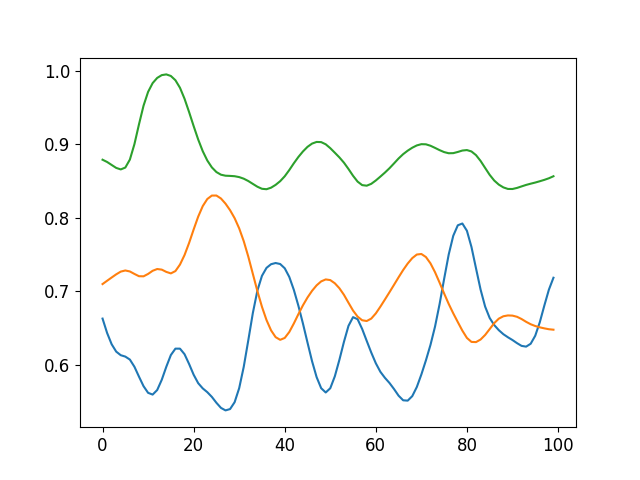

In [19]:
plt.figure()
plt.plot(np.array(correlations_high_rest)/np.array(correlations_low_rest))
plt.plot(np.array(correlations_low_rest)/np.array(correlations_low_half_rest))
plt.plot(np.array(correlations_low_half_rest)/np.array(correlations_low_quarter_rest))

In [21]:
print(np.nanmean(np.array(correlations_high)/np.array(correlations_low)))
print(np.nanmean(np.array(correlations_low)/np.array(correlations_low_half)))
print(np.nanmean(np.array(correlations_low_half)/np.array(correlations_low_quarter)))

0.6636374860312136
0.7499696237412986
0.9074417426604379
